In [28]:
import os
import cv2
import pycolmap
from hloc.utils import viz_3d
import numpy as np
import pixtrack.utils.pose_utils as pose_utils
from pixloc.utils.colmap import Camera as ColCamera
from pixloc.pixlib.geometry import Camera as PixCamera, Pose
import matplotlib.pyplot as plt
from pixtrack.utils.ingp_utils import load_nerf2sfm, initialize_ingp, sfm_to_nerf_pose, nerf_to_sfm_pose
from pixtrack.visualization.run_vis_on_poses import get_nerf_image
from scipy.spatial.transform import Rotation as R

In [29]:
from pixtrack.utils.ingp_utils import get_nerf_aabb_from_sfm

In [30]:
sfm_path = '/home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/aug_nerf_sfm/ref/'
model = pycolmap.Reconstruction(sfm_path)


nerf_path = '/home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/instant-ngp/snapshots/weights.msgpack'
nerf2sfm_path = '/home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/pixsfm/dataset/nerf2sfm.pkl'
nerf2sfm = load_nerf2sfm(nerf2sfm_path)
aabb = get_nerf_aabb_from_sfm(sfm_path, nerf2sfm_path)
testbed = initialize_ingp(nerf_path, aabb=aabb)#, aabb=aabb_with_table)

23:26:52 INFO     Loading network config from: /home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/instant-ngp/snapshots/weights.msgpack
23:26:52 INFO     GridEncoding:  Nmin=16 b=1.51572 F=2 T=2^19 L=16
23:26:52 INFO     Density model: 3--[HashGrid]-->32--[FullyFusedMLP(neurons=64,layers=3)]-->1
23:26:52 INFO     Color model:   3--[Composite]-->16+16--[FullyFusedMLP(neurons=64,layers=4)]-->3
23:26:52 INFO       total_encoding_params=13074912 total_network_params=10240


In [31]:
from pixloc.pixlib.geometry import Camera, Pose

In [32]:
point_ids = []
points3d_in_sfm = []
for point_id in model.points3D:
    points3d_in_sfm.append(model.points3D[point_id].xyz)

points3d_in_sfm = np.array(points3d_in_sfm)
points3d_in_sfm = np.hstack((points3d_in_sfm, np.ones((points3d_in_sfm.shape[0], 1))))

sfm_in_camera = np.linalg.inv(pose_utils.get_camera_in_world_from_colmap_image(model.images[90]))
points3d_in_sfm_camera_frame = np.dot(
    sfm_in_camera, points3d_in_sfm.T
).T
points3d_in_sfm_camera_frame = points3d_in_sfm_camera_frame[:, :-1]

points3d_in_nerf_camera = []
for point_id, point in enumerate(points3d_in_sfm_camera_frame):
    point_ids.append(point)
    pose_placeholder = np.eye(4)
    pose_placeholder[:3, -1] = point[:3]
    point_in_nerf = sfm_to_nerf_pose(nerf2sfm=nerf2sfm, sfm_pose=pose_placeholder)[:3, -1]
    points3d_in_nerf_camera.append(point_in_nerf)

points3d_in_nerf_camera = np.array(points3d_in_nerf_camera)

In [33]:
import math
def get_nerf_depth_image(testbed, nerf_pose, camera):
    spp = 8
    width, height = camera.size
    width = int(width)
    height = int(height)
    fl_x = float(camera.f[0])
    angle_x = math.atan(width / (fl_x * 2)) * 2

    testbed.fov = angle_x * 180 / np.pi
    testbed.set_nerf_camera_matrix(nerf_pose[:3, :])
    testbed.render_mode = testbed.render_mode.Depth

    nerf_img = testbed.render(width, height, spp, True)
    #nerf_img = nerf_img[:, :, :3] * 255.
    #nerf_img = nerf_img.astype(np.uint8)
    testbed.render_mode = testbed.render_mode.Shade
    return nerf_img

def get_nerf_image(testbed, nerf_pose, camera):
    spp = 8
    width, height = camera.size
    width = int(width)
    height = int(height)
    fl_x = float(camera.f[0])
    angle_x = math.atan(width / (fl_x * 2)) * 2

    testbed.fov = angle_x * 180 / np.pi
    testbed.set_nerf_camera_matrix(nerf_pose[:3, :])

    nerf_img = testbed.render(width, height, spp, True)
    nerf_img = nerf_img[:, :, :3] * 255.
    nerf_img = nerf_img.astype(np.uint8)
    return nerf_img

In [167]:
cIw = np.linalg.inv(sfm_in_camera)
nerf_pose = sfm_to_nerf_pose(nerf2sfm, cIw)
camera = model.cameras[1]

camera = ColCamera(
    cIw, 
    camera.model_name,
    int(camera.width),
    int(camera.height),
    camera.params
)
f, cy, cx, d  = camera.params.tolist()
camera = PixCamera.from_colmap(camera)
camera = camera.scale(1.0)
pts_in_image = camera.world2image(points3d_in_sfm_camera_frame)
project_image_points = pts_in_image[0].cpu().numpy()
nerf_depth_img = get_nerf_depth_image(testbed, nerf_pose, camera)
nerf_rgb_img = get_nerf_image(testbed, nerf_pose, camera)
intrisics = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])

In [203]:
points_from_depth = []
points_from_depth2 = []

sfm_scaling_factor = 3.0 / nerf2sfm["avglen"]
depth_closeness_threshold = 0.01 * sfm_scaling_factor
alpha_threshold = 0.1
min_depth_threshold = 1e-2

temp_sfm_pts = points3d_in_sfm_camera_frame * sfm_scaling_factor
skipped_by_depth = 0
skipped_by_alpha = 0 
skipped_by_mismatch = 0
depth_at_points1 = []
for num, pt in enumerate(project_image_points):
    depth_at_point = nerf_depth_img[int(pt[1]), int(pt[0])][0] 
    depth_at_points1.append(depth_at_point)
    alpha_at_point = nerf_depth_img[int(pt[1]), int(pt[0])][3]
    if np.less_equal(depth_at_point, min_depth_threshold):
        skipped_by_depth += 1
        continue
    if alpha_at_point < alpha_threshold:
        skipped_by_alpha += 1
        continue
    point_from_depth = [
        (pt[0].item() - cx) * depth_at_point/ f, (pt[1].item() - cy) * depth_at_point/ f, depth_at_point
    ]
    if np.isclose(temp_sfm_pts[num][2], point_from_depth[2], atol=depth_closeness_threshold):
        points_from_depth.append(temp_sfm_pts[num])
    else:
        skipped_by_mismatch += 1        
    continue

print(skipped_by_depth, skipped_by_alpha, skipped_by_mismatch)
points_from_depth = np.array(points_from_depth)

print(temp_sfm_pts.shape)

76 145 7152
(14109, 3)


In [204]:
depths_at_points = nerf_depth_img[project_image_points[:, 1].astype(int), project_image_points[:, 0].astype(int), 0]
alphas_at_points = nerf_depth_img[project_image_points[:, 1].astype(int), project_image_points[:, 0].astype(int), -1]


visible_indices = np.where(
    (depths_at_points >= min_depth_threshold) &\
    (alpha_at_point >= alpha_threshold) & \
    np.isclose(temp_sfm_pts[:, 2], depths_at_points, atol=depth_closeness_threshold)
)[0]

points_from_depth1 = np.zeros((visible_indices.shape[0], 3))
points_from_depth1[:, 0] = (project_image_points[visible_indices, 0] - cx) * depth_at_point/ f
points_from_depth1[:, 1] = (project_image_points[visible_indices, 1] - cy) * depth_at_point/ f
points_from_depth1[:, 2] = depths_at_points[visible_indices]

In [225]:
dists = []
for indx in range(points_from_depth.shape[0]):
    dists.append(np.linalg.norm(points_from_depth1[0]- points_from_depth[indx]))

In [226]:
np.min(dists)

0.007861328284289402

In [194]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Scatter3d(
            x=points_from_depth[:, 0], y=points_from_depth[:, 1], z=points_from_depth[:, 2],
            mode='markers', marker=dict(
            size=2,
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8)),
        go.Scatter3d(
            x=temp_sfm_pts[:, 0], y=temp_sfm_pts[:, 1], z=temp_sfm_pts[:, 2],
            mode='markers', marker=dict(
            size=2,
            colorscale='gray',   # choose a colorscale
            opacity=0.8)
        )
    ]
)
fig.update_layout(scene_aspectmode='cube')
fig.show()

In [162]:
points_from_depth.shape

(6736, 3)

In [178]:
points_from_depth_proj = np.dot(intrisics, points_from_depth.T).T
points_from_depth_proj[:, 0] /= points_from_depth_proj[:, 2]
points_from_depth_proj[:, 1] /= points_from_depth_proj[:, 2]
points_from_depth_proj[:, 2] /= points_from_depth_proj[:, 2]
points_from_depth_proj = points_from_depth_proj[:, :2]

In [179]:
nerf_rgb_img_c = nerf_rgb_img.copy()
for pt in points_from_depth_proj:
    nerf_rgb_img_c = cv2.circle(
        nerf_rgb_img_c, center=(int(pt[0]),int(pt[1])), radius=1, color=(0, 255, 0), thickness=-1)

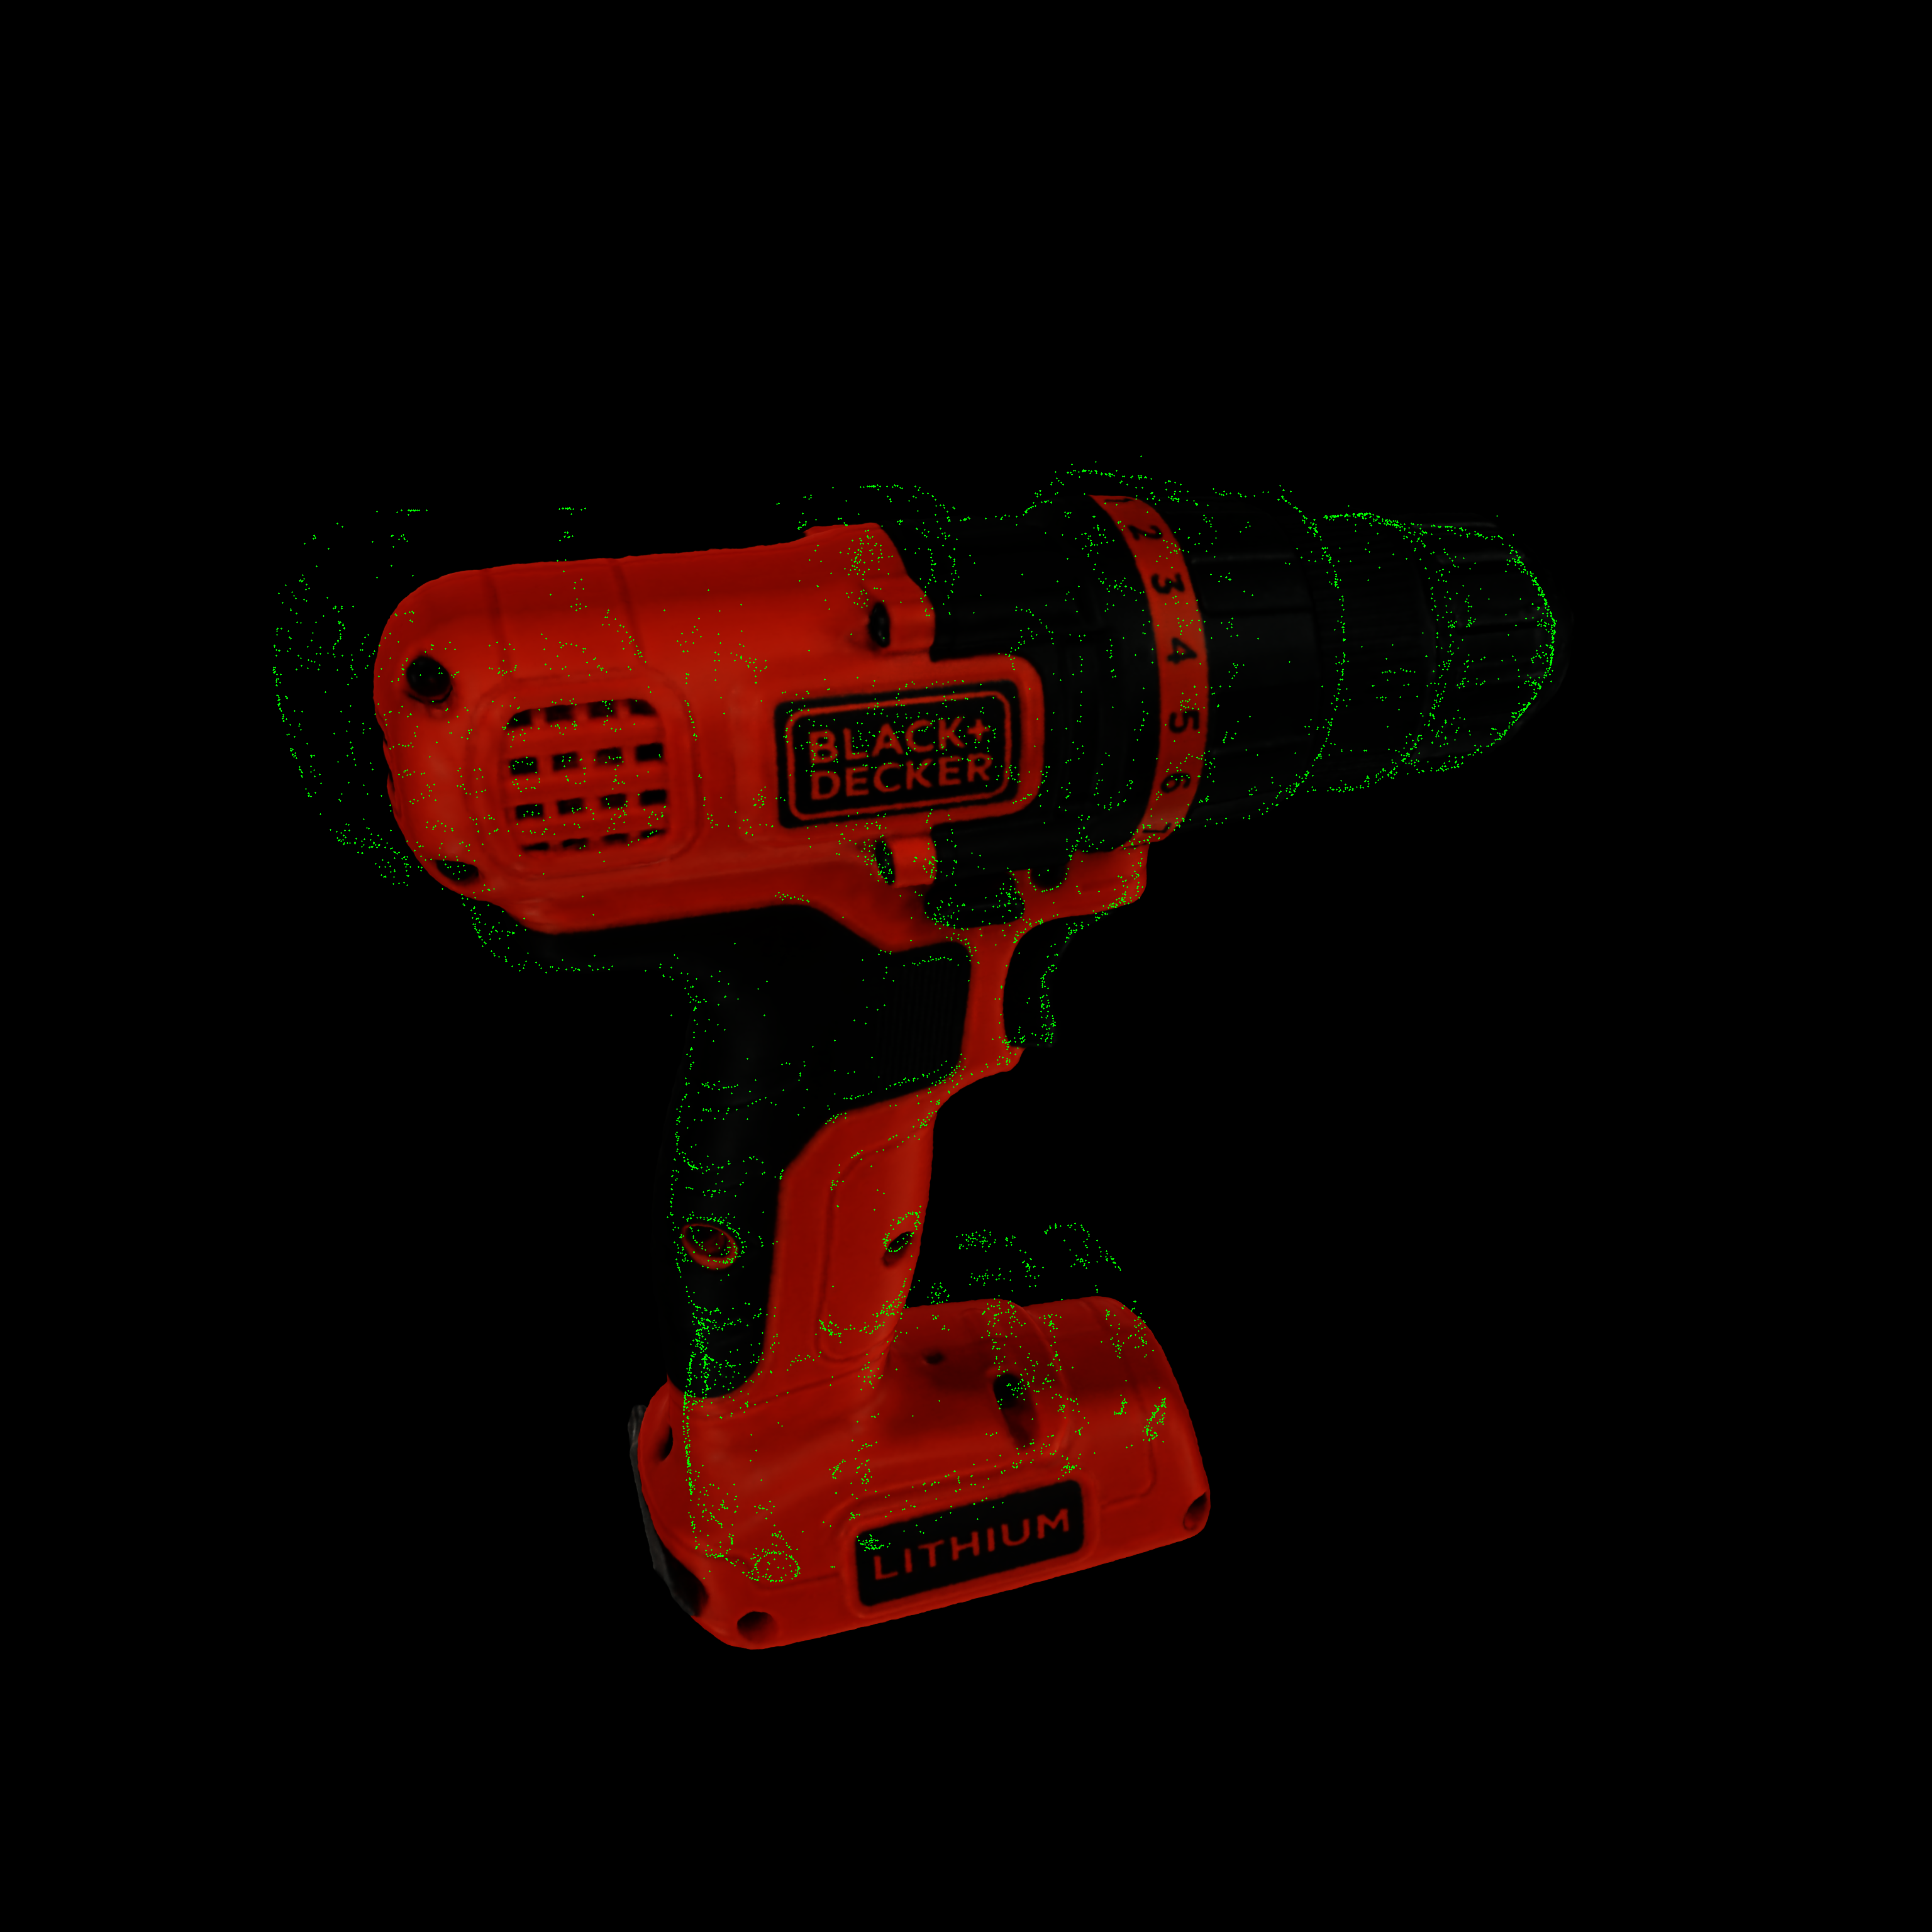

In [180]:
Image.fromarray(nerf_rgb_img_c)